# Coding and Financial Analysis with AutoGen
This notebook uses the following agents:

1. __Code writer__: Uses an LLM to generate Python or Shell code to solve a given financial analysis task
2. __Code executor__: Execudes the code. Also acts as interface to the user who defines the task and reviews results

In [1]:
from dotenv import load_dotenv, find_dotenv
import os
from autogen.coding import LocalCommandLineCodeExecutor, DockerCommandLineCodeExecutor
from autogen import ConversableAgent, AssistantAgent, UserProxyAgent
import datetime
from IPython.display import Image

load_dotenv(find_dotenv())

aoai_endpoint_useast = os.getenv("AOAI_ENDPOINT_USEAST")
aoai_key_useast = os.getenv("AOAI_KEY_USEAST")
oai_key = os.getenv("OAI_KEY")

config_list = [
    {'model' : 'gpt-4o-global',
     'azure_endpoint' : aoai_endpoint_useast,
     'api_key': aoai_key_useast,
     'api_type' : 'azure',
     'api_version' : '2024-05-01-preview'}
]

# for LLM based agents
llm_config = {
    "cache_seed": 0,
    "temperature": 0,
    "seed" : 0,
    "config_list": config_list,
    "timeout": 120,
}

## Allow freestyle Coding by the LLM

In [2]:
# clear temp coding folder
os.system("rm -rf my_code")
os.system("mkdir my_code")

# Docker must be available on the system
executor = DockerCommandLineCodeExecutor(
    timeout=60,
    work_dir="my_code",
)

# executes Python code in specified folder
code_executor_agent = UserProxyAgent(
    name="code_executor_agent",
    llm_config=False,
    code_execution_config={"executor": executor},
    human_input_mode="TERMINATE",
    # default_auto_reply="Please continue. If everything is done, reply 'TERMINATE'.",
)

# use LLM to generate code
code_writer_agent = AssistantAgent(
    name="code_writer_agent",
    llm_config=llm_config,
    code_execution_config=False,
    human_input_mode="NEVER",
)

code_writer_agent_system_message = code_writer_agent.system_message

In [3]:
today = datetime.datetime.now().date()
message = f"""Today is {today}. Create a plot showing stock gain YTD for META and TLSA as time series.
Make sure the code is in markdown code block and save the figure to a file ytd_stock_gains.png."""

In [4]:
chat_result = code_executor_agent.initiate_chat(
    code_writer_agent,
    message=message,
    max_turns=8,
)

code_executor_agent (to code_writer_agent):

Today is 2024-08-15. Create a plot showing stock gain YTD for META and TLSA as time series.
Make sure the code is in markdown code block and save the figure to a file ytd_stock_gains.png.

--------------------------------------------------------------------------------
code_writer_agent (to code_executor_agent):

To create a plot showing the year-to-date (YTD) stock gains for META and TSLA, we need to follow these steps:

1. **Fetch the stock data**: Use a financial data API to get the stock prices for META and TSLA from the beginning of the year to the current date.
2. **Calculate the YTD gains**: Compute the percentage gain from the start of the year to the current date.
3. **Plot the data**: Create a time series plot of the YTD gains for both stocks.
4. **Save the plot**: Save the plot to a file named `ytd_stock_gains.png`.

We'll use the `yfinance` library to fetch the stock data and `matplotlib` to create the plot. Here is the complete 

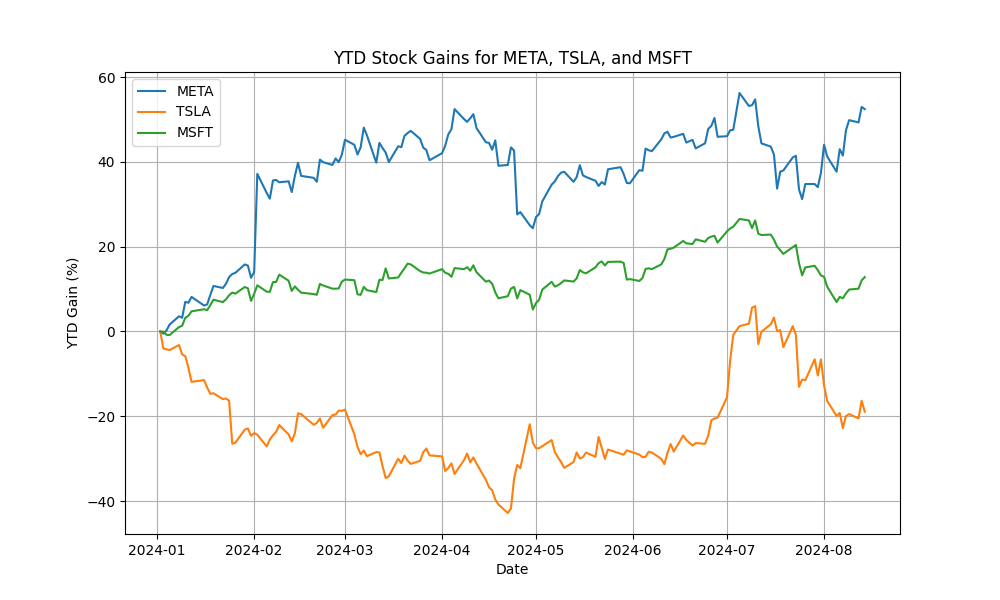

In [5]:
Image(os.path.join("my_code", "ytd_stock_gains.png"))

## Provide User-defined Functions

In [ ]:
def get_stock_prices(stock_symbols, start_date, end_date):
    """Get the stock prices for the given stock symbols between
    the start and end dates.

    Args:
        stock_symbols (str or list): The stock symbols to get the
        prices for.
        start_date (str): The start date in the format 
        'YYYY-MM-DD'.
        end_date (str): The end date in the format 'YYYY-MM-DD'.
    
    Returns:
        pandas.DataFrame: The stock prices for the given stock
        symbols indexed by date, with one column per stock 
        symbol.
    """
    import yfinance

    stock_data = yfinance.download(
        stock_symbols, start=start_date, end=end_date
    )
    return stock_data.get("Close")

def plot_stock_prices(stock_prices, filename):
    """Plot the stock prices for the given stock symbols.

    Args:
        stock_prices (pandas.DataFrame): The stock prices for the 
        given stock symbols.
    """
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 5))
    for column in stock_prices.columns:
        plt.plot(
            stock_prices.index, stock_prices[column], label=column
                )
    plt.title("Stock Prices")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.grid(True)
    plt.savefig(filename)


In [ ]:
# clear temp coding folder
!rm -rf my_code

executor = LocalCommandLineCodeExecutor(
    timeout=60,
    work_dir="my_code",
    functions=[get_stock_prices, plot_stock_prices],
)

code_writer_agent_system_message += executor.format_functions_for_prompt()

In [ ]:
# Default AutoGen system message for code generation plus function definitions from the executor
print(code_writer_agent_system_message)

In [ ]:
code_writer_agent = ConversableAgent(
    name="code_writer_agent",
    system_message=code_writer_agent_system_message,
    llm_config=llm_config,
    code_execution_config=False,
    human_input_mode="NEVER",
)
code_executor_agent = ConversableAgent(
    name="code_executor_agent",
    llm_config=False,
    code_execution_config={"executor": executor},
    human_input_mode="NEVER",
    default_auto_reply=
    "Please continue. If everything is done, reply 'TERMINATE'.",
)

In [ ]:
today = datetime.datetime.now().date()
message = f"""Today is {today}. Create a plot showing stock gain YTD for META, MSFT and TLSA as time series.
Make sure the code is in markdown code block and save the figure to a file ytd_stock_gains.png."""

chat_result = code_executor_agent.initiate_chat(
    code_writer_agent,
    message=message,
    max_turns=8,
)

In [ ]:
Image(os.path.join("my_code", "ytd_stock_gains.png"))